## Trend analysis for any variable 

In [71]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import scipy
from statsmodels.tsa.seasonal import seasonal_decompose
import pymannkendall as mk
import pandas as pd
import swifter
from scipy import interpolate
from sklearn.linear_model import LinearRegression
#import rasterio.mask
from sklearn.metrics import mean_squared_error
from scipy import stats

In [72]:
def load_data(filepath):
    ds=xr.open_mfdataset(filepath,mask_and_scale=True)
    return ds

## Input variable filepath and name

In [115]:
ROOT = "/data/datasets/Projects/TuringCoccolithophoreBlooms"

#filepath = ROOT+"/data/AVHRR_reflectance/monthly_mean/*.nc"
filepath = ROOT+"/no_backup/TuringCoccolithophoreBlooms/regridded_data/CMEMS_wind_speed/*std*.nc"
#filepath = ROOT+"/AVHRR_reflectance/MASKED_AVHRR/rrs_masked_by_sea_ice.nc"
#varname = "filtered_remote_sensing_reflectance"
varname = "wind_speed"
label = 'Wind speed std trend (ms$^{-1}$ Decade$^{-1}$)'
graph_filename = '/lustre_scratch/edu/Figures/met_var_trend/FINAL/wind_speed_std.png'
fileout = '/lustre_scratch/edu/Figures/wind_speed_std.csv'

## Load data

In [116]:
ds = load_data(filepath)
print(ds)
variable = ds[varname]

#ensure no data written as nan
variable.rio.write_nodata(np.nan, inplace=True)
print(f"nodata: {variable.rio.nodata}")

<xarray.Dataset>
Dimensions:     (time: 300, bnds: 2, longitude: 3600, latitude: 1800)
Coordinates:
  * time        (time) datetime64[ns] 1992-01-16T15:00:00 ... 2016-12-16T12:0...
  * longitude   (longitude) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * latitude    (latitude) float64 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    wind_speed  (time, latitude, longitude) float64 dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (12/74)
    CDI:                                            Climate Data Interface ve...
    Conventions:                                    CF-1.7, ACDD-1.3, ISO 8601
    source:                                         Ifremer blended wind REP ...
    institution:                                    Institut Francais de Rech...
    FROM_ORIGINAL_FILE__netcdf_version_id:          4.6.1 of Sep  8 20

In [117]:
#Define coordinates
lons = np.array(ds.longitude)
lats = np.array(ds.latitude)
time = np.array(ds.time)

In [118]:
#For wind variables only for latitudes -80-80 (remove extrapolation from regridding)
variable.loc[:, 80:90,:] = np.nan 
variable.loc[:, -90:-80,:] = np.nan 

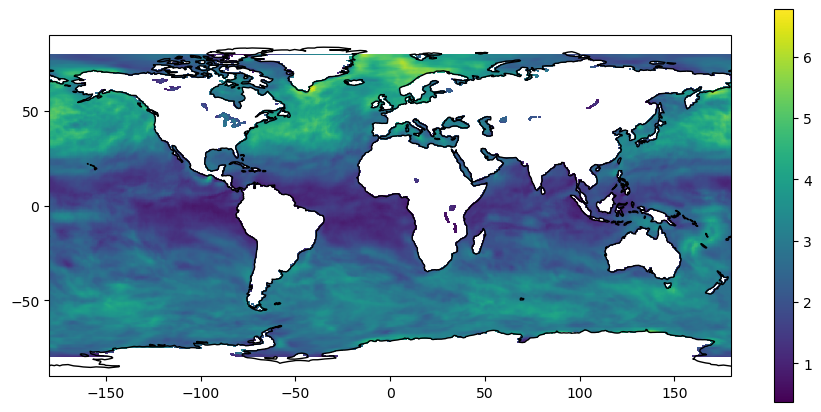

In [119]:
from matplotlib import colors

# Define the figure and each axis
fig, ax = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},figsize=(11,8.5))


ax.coastlines()
pcm = ax.pcolormesh(lons,lats,variable[0,:,:])

cmap = plt.colorbar(pcm,shrink=0.6)
#ax.set_ylim([-80,80])
ax.set_yticks([-50, 0, 50], crs=ccrs.PlateCarree())
ax.set_xticks([-150, -100, -50, 0, 50, 100, 150], crs=ccrs.PlateCarree()) 

#cmap.set_label('Ice fraction trend (decade$^{-1}$)')
plt.show()

In [120]:
## Define trend function

In [121]:
from sklearn import metrics

#Select proportion of data that can be nan for timeseries to be included
#threshold = 0.8

def rolling_mean_trend(data):
    slope = np.nan
    p_vals = np.nan
    r2 = np.nan
    rmse = np.nan
    mk_p = np.nan
    mk_trend = np.nan

    rolling = data.rolling(12,min_periods=12).mean().fillna(method='bfill').fillna(method='ffill')
    reg_ind = data.index - data.index[0]
    rolling.replace([np.inf, -np.inf], np.nan, inplace=True)
    reduce_rolling = rolling[~rolling.isna()]

    reduce_ind = rolling[~rolling.isna()].index
    reduce_ind = reduce_ind - data.index[0]
    dates = np.array(reduce_ind[1:].days/(365*10)).reshape(-1, 1)
    print(rolling)
    if len(reduce_rolling) > 12:
        reg = LinearRegression().fit(dates, reduce_rolling[1:])
        slope = reg.coef_[0]
        print(np.shape(dates))

        #STATS OF FIT
        p_vals = stats_of_regress(reg.predict(dates), reduce_rolling[1:], reg.coef_, dates)
        r2 = reg.score(dates,reduce_rolling[1:])
        rmse = np.sqrt(metrics.mean_squared_error(reduce_rolling[1:],reg.predict(dates)))

        mk_t = mk.original_test(reduce_rolling)
        mk_trend = mk_t.trend
        if mk_t.trend == 'no trend':
            mk_p = np.nan
        else:
            mk_p = mk_t.p
    
    return slope, p_vals, r2, rmse, mk_p, mk_trend

In [122]:
def stats_of_regress(pred, true, coefs, X):
    sse = np.sum((pred - true)**2)/(len(X)-2) 
    standard_error = np.sum((X - np.mean(X))**2)
    sigma = sse/standard_error
    t_stats = coefs / sigma 
    p_vals = 2 * (stats.t.cdf(-np.abs(t_stats), len(X) - 2)) 

    return p_vals 

## Averaging over longhurst provinces

In [124]:
import fiona

mask_path = '/data/datasets/Projects/TuringCoccolithophoreBlooms/province_files/Longhurst_world_v4_2010.shp'

with fiona.open(mask_path) as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

variable.rio.write_crs("WGS84",inplace=True)

<xarray.DataArray 'wind_speed' (time: 300, latitude: 1800, longitude: 3600)>
dask.array<setitem, shape=(300, 1800, 3600), dtype=float64, chunksize=(1, 1800, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1992-01-16T15:00:00 ... 2016-12-16T12:...
  * longitude    (longitude) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * latitude     (latitude) float64 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
    spatial_ref  int64 0
Attributes:
    long_name:              wind speed
    units:                  m s-1
    coverage_content_type:  physicalMeasurement
    _ChunkSizes:            [  1 321 720]
    _FillValue:             nan

In [ ]:
slope = np.zeros(len(shapes))
p_vals = np.zeros(len(shapes))
p_vals[:] = np.nan

r2 = np.zeros(len(shapes))
rmse = np.zeros(len(shapes))
mk_p = np.zeros(len(shapes))
mk_p[:] = np.nan

df = pd.DataFrame(index=variable.time)


for i in range(0,len(shapes)-1):
    name = "province"+str(i)
    if i==2:
        name1="province"+str(i)+"_norwegian"
        name2="province"+str(i)+"_barents"
        clip = variable.rio.clip([shapes[i]])
        print(clip)
        a1 = clip.sel(longitude=slice(-25,10)) 
        a2 = clip.sel(longitude=slice(10,45))
        print(a1)
        df[name1] = np.array((a1).mean(dim=['latitude','longitude'],skipna=True))
        df[name2] = np.array((a2).mean(dim=['latitude','longitude'],skipna=True))
        
    else:
        df[name] = np.array(variable.rio.clip([shapes[i]]).mean(dim=['latitude','longitude'],skipna=True))



<xarray.DataArray 'wind_speed' (time: 300, latitude: 180, longitude: 740)>
dask.array<getitem, shape=(300, 180, 740), dtype=float64, chunksize=(1, 180, 740), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1992-01-16T15:00:00 ... 2016-12-16T12:...
  * longitude    (longitude) float64 -23.45 -23.35 -23.25 ... 50.25 50.35 50.45
  * latitude     (latitude) float64 57.55 57.65 57.75 ... 75.25 75.35 75.45
    spatial_ref  int64 0
Attributes:
    long_name:              wind speed
    units:                  m s-1
    coverage_content_type:  physicalMeasurement
    _ChunkSizes:            [  1 321 720]
<xarray.DataArray 'wind_speed' (time: 300, latitude: 180, longitude: 335)>
dask.array<getitem, shape=(300, 180, 335), dtype=float64, chunksize=(1, 180, 335), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1992-01-16T15:00:00 ... 2016-12-16T12:...
  * longitude    (longitude) float64 -23.45 -23.35 -23.25 ... 9.745 9.85 9.948
  * latitud

In [ ]:
df = df.loc['1993-1-1':'2016-12-30']

In [ ]:
out = df.swifter.apply(rolling_mean_trend)

In [ ]:
cut = out.drop('province2_barents',axis=1)

In [ ]:
print(cut)
slope = cut.iloc[0]
p_vals = cut.iloc[1]
r2 = cut.iloc[2]
std_err = cut.iloc[3]
mk_p = cut.iloc[4] 
mk_trend = cut.iloc[5]
print(mk_trend)

In [ ]:
from shapely.geometry import LineString, MultiPolygon, shape, box

In [ ]:
plt.figure()
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
import cartopy.feature as cfeat

# Define the figure and each axis
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},figsize=(11,8.5))

cmap = plt.cm.coolwarm
norm = colors.Normalize(vmin=-1e-3, vmax=1e-3)
print(min(slope),max(slope))
plt.rcParams['hatch.color'] = 'y'
ax = axs
for i in range(0,len(shapes)-1):

    if i==2:

        nor = box(shape(shapes[i]).bounds[0], shape(shapes[i]).bounds[1], 10, shape(shapes[i]).bounds[3])
        bar = box(10, shape(shapes[i]).bounds[1], shape(shapes[i]).bounds[2], shape(shapes[i]).bounds[3])
        print(shape(shapes[i]).bounds)

        norw_patch = shape(shapes[i]).intersection(nor)
        bar_patch = MultiPolygon(shape(shapes[i]).intersection(bar))
        if out.iloc[4]['province'+str(i)+'_norwegian'] <= 0.05 and out.iloc[4]['province'+str(i)+'_norwegian']!= np.nan and out.iloc[5]['province'+str(i)+'_norwegian']!= 'no trend': # and np.abs(slope[i]) > 2e-7:
            if out.iloc[5]['province'+str(i)+'_norwegian']=='decreasing' and out.iloc[0]['province'+str(i)+'_norwegian']<0:
                ax.add_geometries([norw_patch], crs=ccrs.PlateCarree(), fc=cmap(norm(out.iloc[0]['province'+str(i)+'_norwegian'])), zorder=2,hatch='...',edgecolor='black')
                ax.axis('scaled')
            elif out.iloc[5]['province'+str(i)+'_norwegian']=='increasing' and out.iloc[0]['province'+str(i)+'_norwegian']>0:
                ax.add_geometries([norw_patch], crs=ccrs.PlateCarree(), fc=cmap(norm(out.iloc[0]['province'+str(i)+'_norwegian'])), zorder=2,hatch='...',edgecolor='black')
                ax.axis('scaled')
        else:
            ax.add_geometries([norw_patch], crs=ccrs.PlateCarree(), fc=cmap(norm(out.iloc[0]['province'+str(i)+'_norwegian'])), zorder=2,edgecolor='black')
            print(out['province'+str(i)+'_norwegian'])

        if out.iloc[4]['province'+str(i)+'_barents'] <= 0.05 and out.iloc[4]['province'+str(i)+'_barents']!= np.nan and out.iloc[5]['province'+str(i)+'_barents']!= 'no trend': # and np.abs(slope[i]) > 2e-7:
            if out.iloc[5]['province'+str(i)+'_barents']=='decreasing' and out.iloc[0]['province'+str(i)+'_barents']<0:
                ax.add_geometries([bar_patch], crs=ccrs.PlateCarree(), fc=cmap(norm(out.iloc[0]['province'+str(i)+'_barents'])), zorder=2,hatch='...',edgecolor='black')
                ax.axis('scaled')
            elif out.iloc[5]['province'+str(i)+'_barents']=='increasing' and out.iloc[0]['province'+str(i)+'_barents']>0:
                ax.add_geometries([bar_patch], crs=ccrs.PlateCarree(), fc=cmap(norm(out.iloc[0]['province'+str(i)+'_barents'])), zorder=2,hatch='...',edgecolor='black')
                ax.axis('scaled')
        else:
            ax.add_geometries([bar_patch],crs=ccrs.PlateCarree(),fc=cmap(norm(out.iloc[0]['province'+str(i)+'_barents'])), zorder=2,edgecolor='black')#.convex_hull))
            print(out['province'+str(i)+'_barents'])
    else:
        print(i,mk_trend['province'+str(i)],slope['province'+str(i)])
        if mk_p['province'+str(i)] <= 0.05 and mk_p['province'+str(i)]!= np.nan and mk_trend['province'+str(i)]!= 'no trend': # and np.abs(slope[i]) > 2e-7:
            if mk_trend['province'+str(i)]=='decreasing' and slope['province'+str(i)]<0:
                ax.add_patch(PolygonPatch(shapes[i], fc=cmap(norm(slope['province'+str(i)])), zorder=2,color='black',hatch='...'))
                ax.axis('scaled')
            elif mk_trend['province'+str(i)]=='increasing' and slope['province'+str(i)]>0:
                ax.add_patch(PolygonPatch(shapes[i], fc=cmap(norm(slope['province'+str(i)])), zorder=2,color='black',hatch='...'))
                ax.axis('scaled')
        else: 
            ax.add_patch(PolygonPatch(shapes[i], fc=cmap(norm(out.iloc[0]['province'+str(i)])), zorder=2))
            ax.axis('scaled')
    ax.add_patch(PolygonPatch(shapes[i], fill=False, zorder=3))

ax.add_feature(cfeat.LAND,color='white')
ax.add_feature(cfeat.COASTLINE)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.33, color='k',alpha=0.5)
gl.xlabels_bottom = False
gl.ylabels_right = False

# create the colourbar
ax.set_xlim([-180,180])
ax.set_ylim([-90,90])
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
cbar = plt.colorbar(sm, ax=ax,shrink=0.6)    
cbar.set_label(label)
plt.savefig(graph_filename)

In [ ]:
out.to_csv(fileout)